# Pre-training on Casia webface

## Load the data

In [22]:
import tensorflow as tf, os, cv2, numpy as np
import keras, matplotlib.pyplot as plt

batch_size = 1024
image_size = 112
dataset = keras.utils.image_dataset_from_directory(
    os.path.join('data', 'Casia webface', 'archive', 'casia-webface'),
    labels = 'inferred',
    label_mode = 'int',
    batch_size = batch_size,
    image_size = (image_size, image_size),
    color_mode = 'rgb'
)



Found 490623 files belonging to 10572 classes.


In [23]:
num_classes = 10572

## Configure the hyperparamters

In [4]:
learning_rate = 0.0001
weight_decay = 0.00001
num_epochs = 500
patch_size = 28
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 6
transformer_units = [
    projection_dim * 2,
    projection_dim
]
transformer_layers = 8
mlp_head_units = [
    2048, 
    1024
]


## Date augmentation for better generalization

In [25]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip('horizontal'),
        keras.layers.RandomRotation(factor = 0.02),
        keras.layers.RandomZoom(height_factor = 0.2, width_factor = 0.2)
    ],
    name = 'data_augmentation'
)

## Patch creation layer

In [26]:
@keras.saving.register_keras_serializable("Patches")
class Patches(keras.layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
    
    def call(self, images):
        input_shape = keras.ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size = self.patch_size)
        patches = keras.ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels
            )
        )

        return patches

    def get_config(self):
        config = super().get_config()
        config.update({'patch_size' : self.patch_size})
        return {**config, 'patch_size' : self.patch_size}

## Demonstrate the patches in action

In [27]:
image = 0
for batch in dataset:
    image = batch[0][10]
    break

image = keras.ops.convert_to_tensor([image])

In [28]:
patches = Patches(patch_size)(image)

Image size: 112 X 112
Patch size: 28 X 28
Patches per image: 16
Elements per patch: 2352


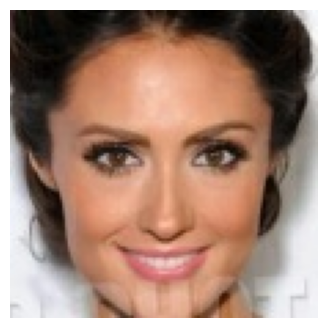

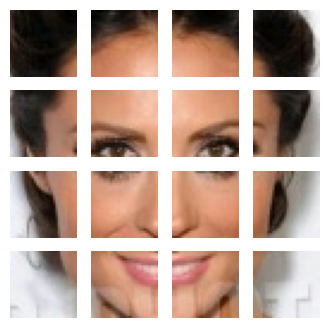

In [29]:
plt.figure(figsize = (4, 4))
plt.imshow(image[0].numpy().astype(np.uint8))
plt.axis('off')


n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = keras.ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(keras.ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

## Patch encoding layer

In [30]:
@keras.saving.register_keras_serializable("PatchEncoder")
class PatchEncoder(keras.layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.projection = keras.layers.Dense(units = self.projection_dim)
        self.position_embedding = keras.layers.Embedding(
            input_dim = num_patches,
            output_dim = projection_dim
        )
    
    def call(self, patches):
        positions = keras.ops.expand_dims(
            keras.ops.arange(start = 0, stop = self.num_patches, step = 1), axis = 0
        )
        projected_patches = self.projection(patches)
        encoded = projected_patches + self.position_embedding(positions)
        
        return encoded

    def get_config(self):
        config = super().get_config()
        return {**config, 'num_patches' : self.num_patches, 'projection_dim' : self.projection_dim}


## Build the Vision Transformer

In [31]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = keras.layers.Dense(units, activation=keras.activations.gelu)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
    return x

In [32]:
def create_vit_classifier():
    inputs = keras.Input(shape=(image_size, image_size, 3))
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = keras.layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = keras.layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = keras.layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = keras.layers.Flatten()(representation)
    representation = keras.layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    outputs = keras.layers.Dense(num_classes, activation = keras.activations.softmax)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

## Training

In [ ]:
checkpoint_path = os.path.join('data', 'checkpoint', 'ViT 1', 'ViT 1.weights.h5')

optimizer = keras.optimizers.AdamW(
    learning_rate = learning_rate,
    weight_decay = weight_decay
)

model = create_vit_classifier()
model.compile(
    optimizer = optimizer,
    loss = keras.losses.SparseCategoricalCrossentropy(),
    metrics = [
        keras.metrics.SparseCategoricalAccuracy(name = 'accuracy'),
        keras.metrics.SparseTopKCategoricalAccuracy(name = 'top_5_accuracy')
    ]
)

model.load_weights(checkpoint_path)

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor = 'accuracy',
    save_best_only = True,
    save_weights_only = True
)

learning_rate_scheduler = keras.callbacks.ReduceLROnPlateau('accuracy', 0.8)

history = model.fit(
    dataset,
    batch_size = batch_size,
    epochs = num_epochs,
    callbacks = [checkpoint_callback, learning_rate_scheduler]
)

## Pre-training on LFW

In [33]:
import tensorflow as tf, os, cv2, numpy as np
import keras, matplotlib.pyplot as plt
batch_size = 128
image_size = 112
learning_rate = 0.0001
weight_decay = 0.00001
dataset = keras.utils.image_dataset_from_directory(
    os.path.join('data', 'LFW', 'archive', 'lfw_funneled'),
    labels = 'inferred',
    label_mode = 'int',
    batch_size = batch_size,
    image_size = (image_size, image_size),
    color_mode = 'rgb'
)
num_classes = 5749

Found 13233 files belonging to 5749 classes.


In [ ]:
optimizer = keras.optimizers.AdamW(
    learning_rate = learning_rate,
    weight_decay = weight_decay
)

model = create_vit_classifier()
model.compile(
    optimizer = optimizer,
    loss = keras.losses.SparseCategoricalCrossentropy(),
    metrics = [
        keras.metrics.SparseCategoricalAccuracy(name = 'accuracy'),
        keras.metrics.SparseTopKCategoricalAccuracy(name = 'top_5_accuracy')
    ]
)
checkpoint_path = os.path.join('data', 'checkpoint', 'ViT 2', 'ViT 2.weights.h5')
model.load_weights(checkpoint_path)
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor = 'accuracy',
    save_best_only = True,
    save_weights_only = True
)

history = model.fit(
    dataset,
    batch_size = batch_size,
    epochs = num_epochs,
    callbacks = [checkpoint_callback]
)

## Fine tuning

In [2]:
import cv2, numpy as np, keras, VIT, os
from matplotlib import pyplot as plt
image_size = 112
batch_size = 128
train, test = keras.utils.image_dataset_from_directory(
    os.path.join('data', 'Fine tuning DB'),
    labels = 'inferred',
    label_mode = 'int',
    batch_size = batch_size,
    image_size = (image_size, image_size),
    validation_split = 0.2,
    subset = 'both',
    seed = 100
)
num_classes = 2


Found 13487 files belonging to 2 classes.
Using 10790 files for training.
Using 2697 files for validation.


In [7]:
optimizer = keras.optimizers.AdamW(
    learning_rate = learning_rate,
    weight_decay = weight_decay
)

model = VIT.create_vit_classifier(num_classes = num_classes)
model.compile(
    optimizer = optimizer,
    loss = keras.losses.SparseCategoricalCrossentropy(),
    metrics = [
        keras.metrics.SparseCategoricalAccuracy(name = 'accuracy'),
        keras.metrics.SparseTopKCategoricalAccuracy(name = 'top_5_accuracy')
    ]
)

model.load_weights(
    os.path.join('data', 'checkpoint', 'ViT 1', 'ViT 1.weights.h5'),
    skip_mismatch = True,
)


checkpoint_path = os.path.join('data', 'checkpoint', 'ViT 3', 'ViT 3.weights.h5')
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor = 'accuracy',
    save_best_only = True,
    save_weights_only = True
)

history = model.fit(
    train,
    batch_size = batch_size,
    epochs = 25,
    callbacks = [checkpoint_callback]
)

Epoch 1/25


/home/thoalfeqar/anaconda3/envs/tf/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 280 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/thoalfeqar/anaconda3/envs/tf/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:591: UserWarning: A total of 1 objects could not be loaded. Example error message for object <Dense name=dense_19, built=True>:

The shape of the target variable and the shape of the target value in `variable.assign(value)` must match. variable.shape=(1024, 2), Received: value.shape=(1024, 10572). Target variable: <KerasVariable shape=(1024, 2), dtype=float32, path=dense_19/kernel>

List of objects that could not be loaded:
[<Dense name=dense_19, built=True>]
  warnings.warn(msg)
I0000 00:00:1731666620.241763    7824 cuda_dnn.cc:529] Loaded cuDNN version 90300


85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.7310 - loss: 0.6377 - top_5_accuracy: 1.0000
Epoch 2/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.8814 - loss: 0.2689 - top_5_accuracy: 1.0000
Epoch 3/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.9321 - loss: 0.1672 - top_5_accuracy: 1.0000
Epoch 4/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9634 - loss: 0.0984 - top_5_accuracy: 1.0000
Epoch 5/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.9768 - loss: 0.0611 - top_5_accuracy: 1.0000
Epoch 6/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9814 - loss: 0.0514 - top_5_accuracy: 1.0000
Epoch 7/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.9816 - loss: 0.0483 - top_5_accuracy: 1.0000
Epoch 8/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.9837 - loss: 0.0401 - top_5_accuracy: 1.0000
Epoch 9/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.9886 - loss: 0.0366 - top_5_accuracy: 1.0000
Epoch 10/25
85/85 ━━

In [8]:
model.evaluate(test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9988 - loss: 0.0023 - top_5_accuracy: 1.0000


[0.0020167005714029074, 0.9988876581192017, 1.0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


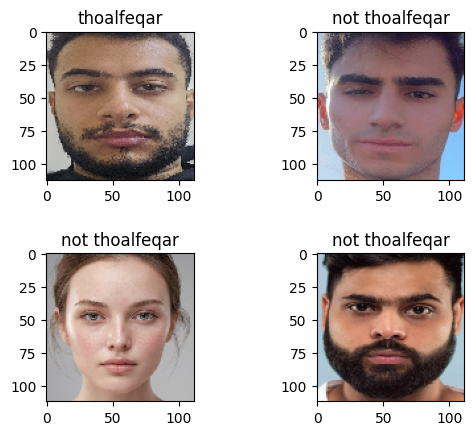

In [9]:

model = VIT.create_vit_classifier(2)
model.load_weights(os.path.join('data', 'checkpoint', 'ViT 3', 'ViT 3.weights.h5'))
classes = ['thoalfeqar', 'not thoalfeqar']
image1 = cv2.resize(cv2.imread(os.path.join('data', 'test images', '7.jpg'))[:, :, ::-1], (112, 112))
image2 = cv2.resize(cv2.imread(os.path.join('data', 'test images', '4.jpg'))[:, :, ::-1], (112, 112))
image3 = cv2.resize(cv2.imread(os.path.join('data', 'test images', '6.png'))[:, :, ::-1], (112, 112))
image4 = cv2.resize(cv2.imread(os.path.join('data', 'test images', '5.png'))[:, :, ::-1], (112, 112))
output_class1 = np.argmax(model.predict(np.array([image1])))
output_class2 = np.argmax(model.predict(np.array([image2])))
output_class3 = np.argmax(model.predict(np.array([image3])))
output_class4 = np.argmax(model.predict(np.array([image4])))

plt.subplots_adjust(hspace = 0.5)
plt.subplot(2, 2, 1)
plt.imshow(image1)
plt.title(classes[output_class1])
plt.subplot(2, 2, 2)
plt.imshow(image2)
plt.title(classes[output_class2])
plt.subplot(2, 2, 3)
plt.imshow(image3)
plt.title(classes[output_class3])
plt.subplot(2, 2, 4)
plt.imshow(image4)
plt.title(classes[output_class4])

plt.show()

In [10]:
keras.models.save_model(model, os.path.join('data', 'checkpoint' ,'Final model', 'Final model.keras'))

## Model Optimization